In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# File paths
Cleanfile = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"


# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

# Load data
df_clean = pd.read_csv(Cleanfile, dtype=dtype_spec, low_memory=False)
drop =["Unnamed: 0","Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)

df_clean.drop_duplicates(inplace=True)

In [4]:
#df_clean.info()

In [5]:
# Encode categorical variables
#label_encoders = {}
#for column in df_clean.select_dtypes(include=['category']).columns:
    #label_encoders[column] = LabelEncoder()
    #df_clean[column] = label_encoders[column].fit_transform(df_clean[column])

# Display the first few rows to verify
#df_clean.head()

In [6]:
# Define the features for each energy type
features_dict = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [7]:
# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series(), []
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series(), []
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y, features

In [8]:
# Ridge Regression function with RandomizedSearchCV and enhanced visualization
def ridge_regression_with_random_search(df, energy_types, features_dict, alphas):
    # Prepare data
    X, y, feature_names = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values
    X = X.fillna(X.mean())  # Avoid SettingWithCopyWarning
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Dimensionality Reduction
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_pca = pca.fit_transform(X_scaled)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Parameter grid for alpha
    param_grid = {'alpha': alphas}
    
    # Ridge Regression with RandomizedSearchCV
    ridge = Ridge()
    random_search = RandomizedSearchCV(ridge, param_distributions=param_grid, n_iter=100, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Best model
    best_ridge = random_search.best_estimator_
    best_alpha = random_search.best_params_['alpha']
    
    # Predictions with best model
    y_pred_best = best_ridge.predict(X_test)
    
    # Evaluation of best model
    best_r2 = r2_score(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Best Alpha: {best_alpha}")
    print(f"Best R^2 Score: {best_r2}")
    print(f"Mean Squared Error: {mse_best}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter plot of actual vs predicted for best model
    sns.scatterplot(x=y_test, y=y_pred_best, ax=axes[0])
    axes[0].set_xlabel('Actual CO2_wltp')
    axes[0].set_ylabel('Predicted CO2_wltp')
    axes[0].set_title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    
    # R^2 scores vs alpha plot
    results_df = pd.DataFrame(random_search.cv_results_)
    sns.lineplot(x='param_alpha', y='mean_test_score', data=results_df, ax=axes[1])
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Mean CV R^2 Score')
    axes[1].set_title('Mean CV R^2 Score vs Alpha')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance for best model
    original_feature_importances = np.dot(pca.components_.T, best_ridge.coef_)
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(original_feature_importances)})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    print("Feature Importances:")
    for feature, coef in zip(coef_df['Feature'], coef_df['Coefficient']):
        print(f"{feature}: {coef}")
    
    # Visualization of feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()
    
    return best_ridge, best_r2, mse_best

Energy Type: petrol
Best Alpha: 1232.8467394420684
Best R^2 Score: 0.8059595090459922
Mean Squared Error: 156.19161082523092


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


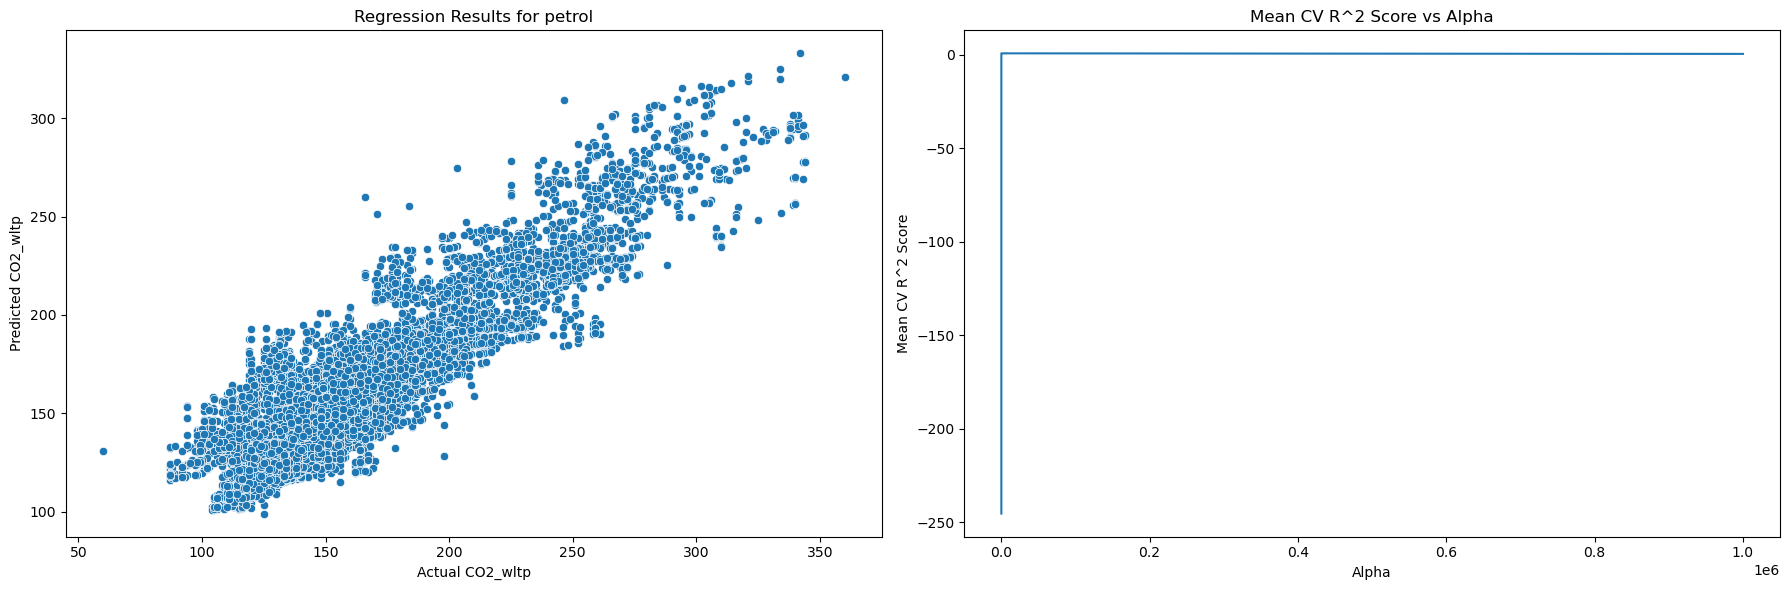

Feature Importances:
Power_KW: 8.44055369681243
Engine_cm3: 8.226492300039524
year: 6.715587864281845
Kg_veh: 4.043964140051647
Test_mass: 3.8877653603357447
Fuel consumption: 3.7690869948892836
Erwltp (g/km): 1.304545412852672
Axle_width_other_mm: 0.5991661429126558
Eco-innovation program: 0.46503615596575276
Axle_width_steer_mm: 0.19997916536517124
El_Consumpt_whkm: 0.1729458713980837
Wheelbase_mm: 0.06584907960015585


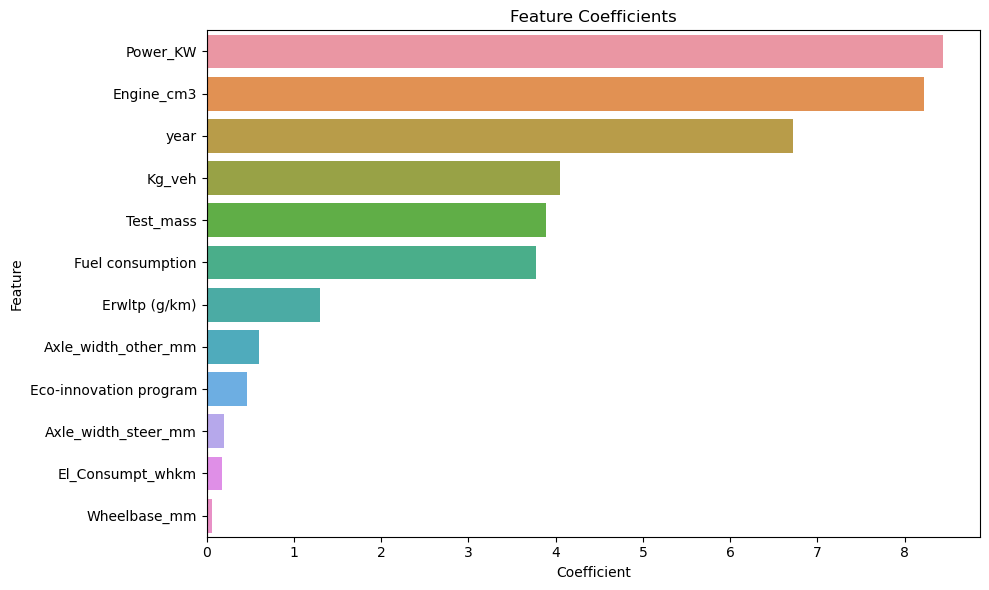

Energy Type: diesel
Best Alpha: 2154.4346900318865
Best R^2 Score: 0.7662530571581203
Mean Squared Error: 155.9458435259169


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


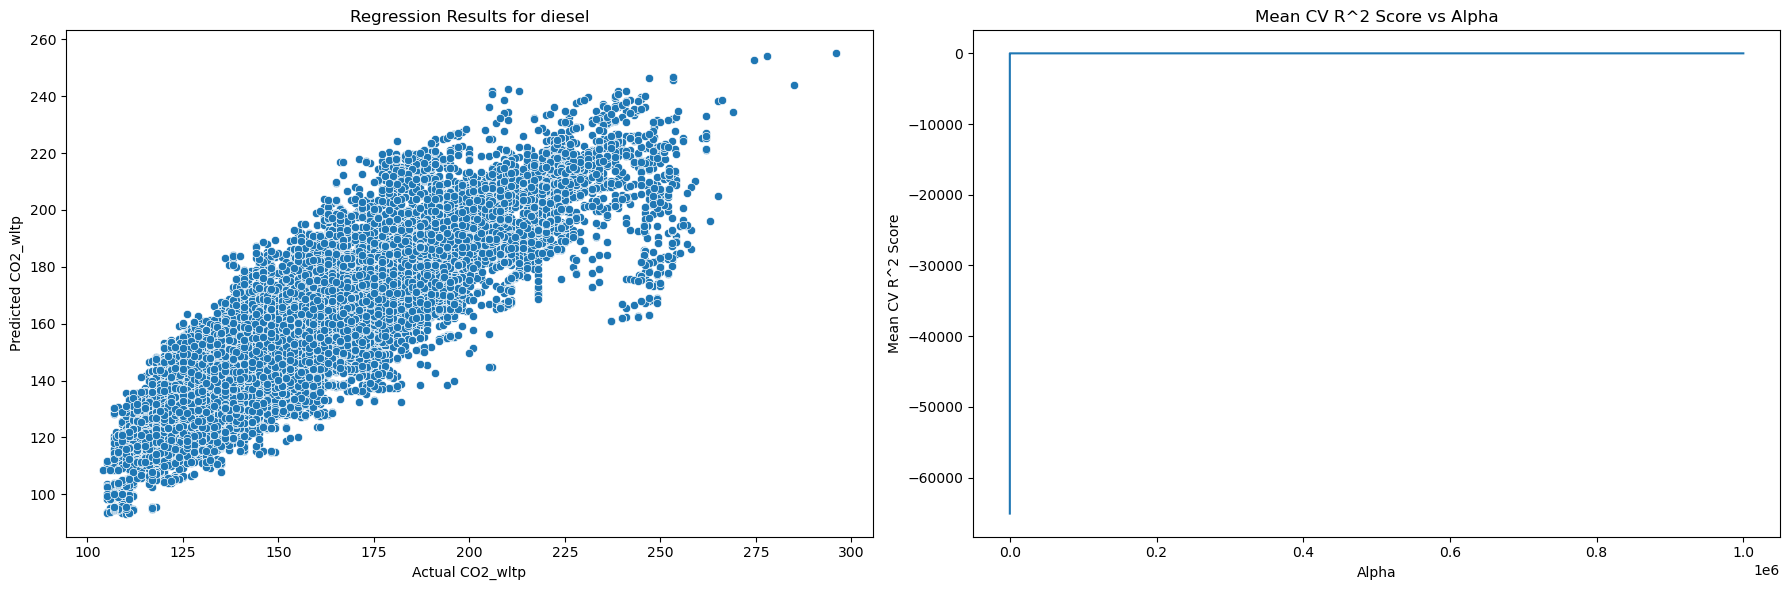

Feature Importances:
year: 5.956670572401267
Test_mass: 4.912176620045434
Kg_veh: 4.654027682564757
Fuel consumption: 4.3171193289464025
Engine_cm3: 3.679785400635814
Power_KW: 3.5094528290998905
Wheelbase_mm: 3.1734193413004763
Axle_width_other_mm: 3.0407613275779712
Eco-innovation program: 2.448164921191827
Axle_width_steer_mm: 1.8456463881260128
Erwltp (g/km): 0.3460180065522801
El_Consumpt_whkm: 0.013359019470607914


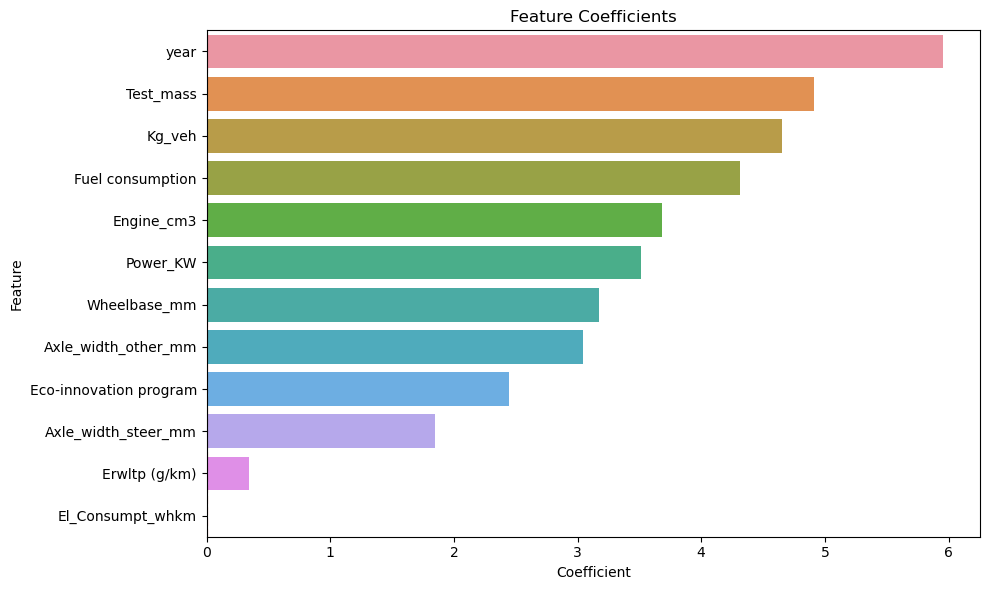

Energy Type: lpg
Best Alpha: 2.6560877829466896
Best R^2 Score: 0.9222178641127886
Mean Squared Error: 19.112892462056553


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


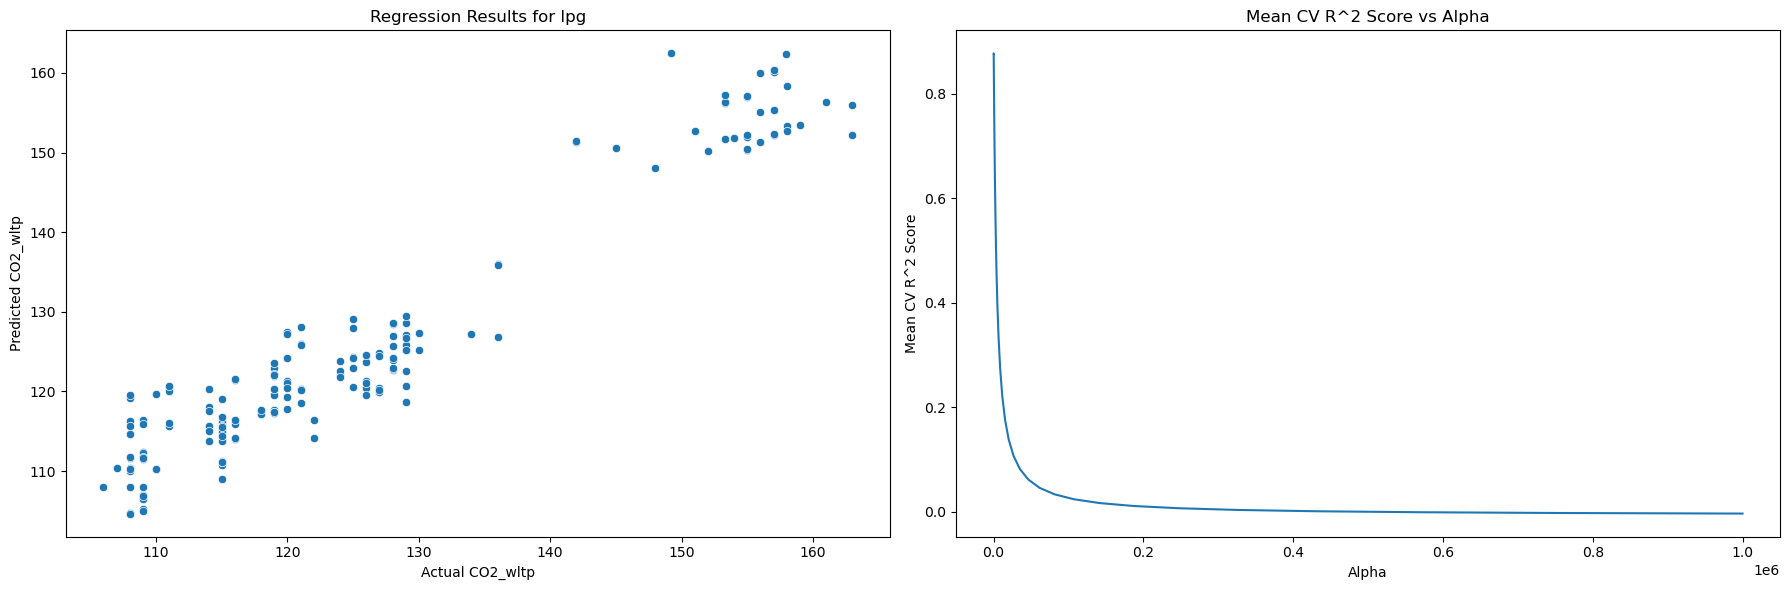

Feature Importances:
Engine_cm3: 6.516399540069522
year: 5.624338005607415
Test_mass: 4.444556988126622
Kg_veh: 4.053418963781569
Axle_width_steer_mm: 1.8606698691573147
Power_KW: 1.4932840146716289
Axle_width_other_mm: 1.3141514591334083
Eco-innovation program: 0.8594689337777958
Erwltp (g/km): 0.7583434686413472
Fuel consumption: 0.49101255177444125
Wheelbase_mm: 0.2934743548169747
Electric range (km): 0.0


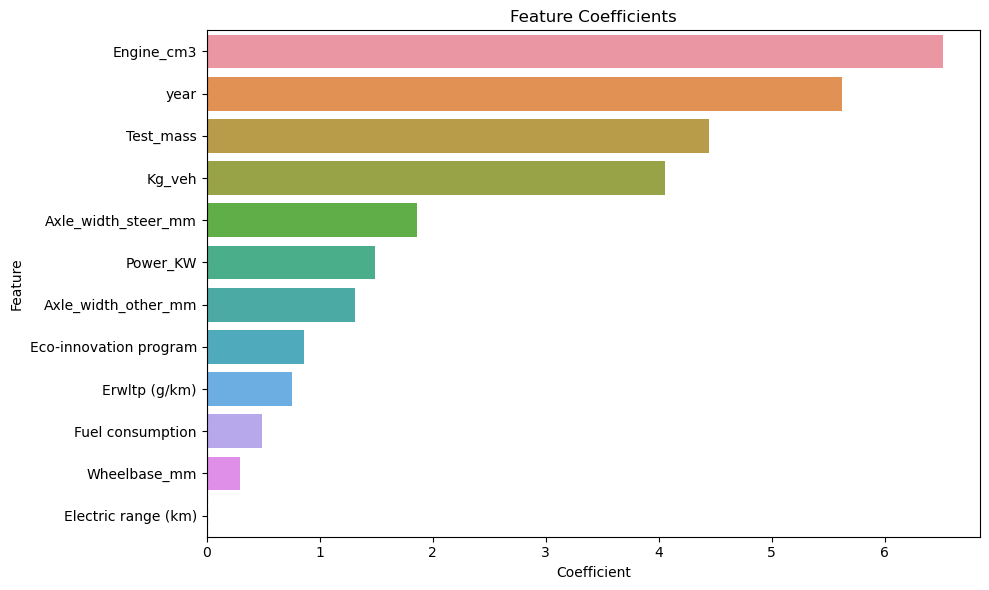

Energy Type: hybrid petrol
Best Alpha: 57.2236765935022
Best R^2 Score: 0.5681541071907865
Mean Squared Error: 170.42094727944792


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


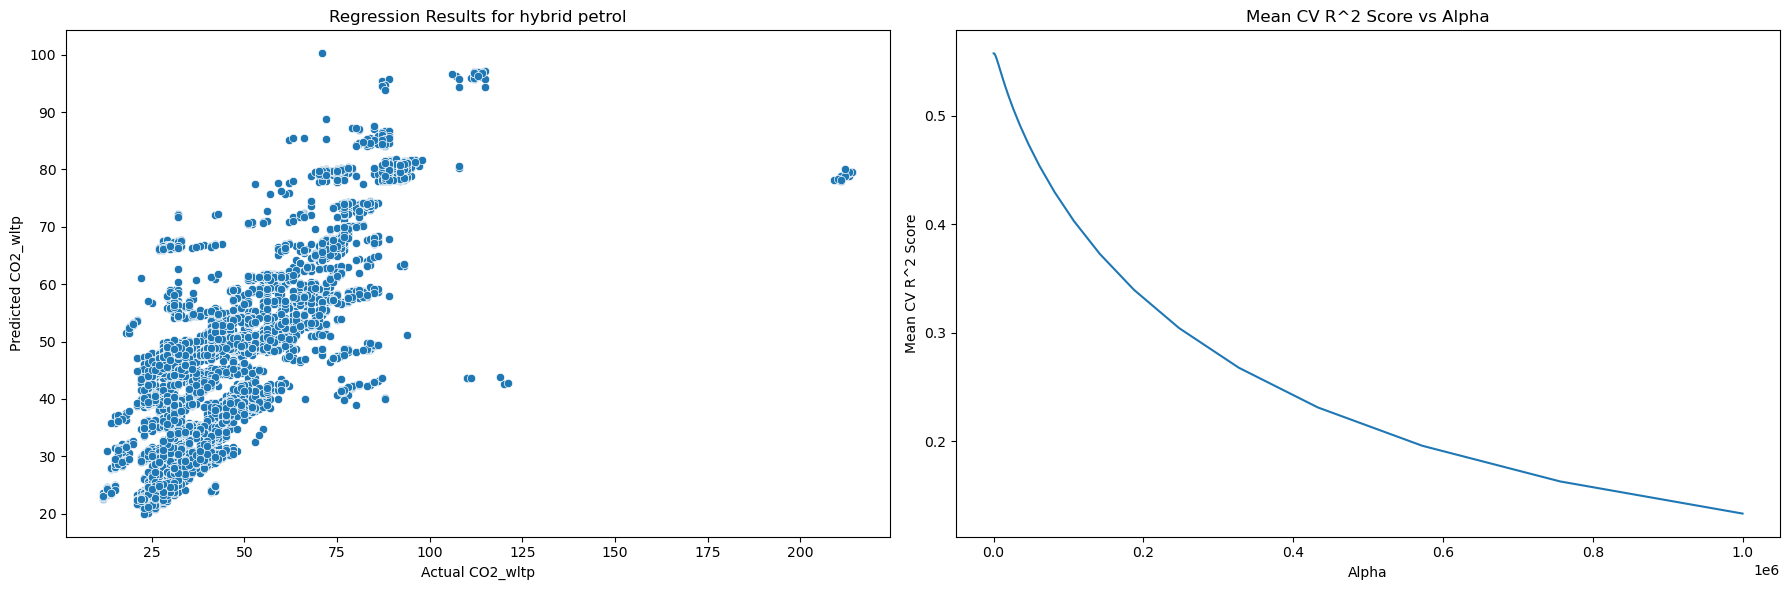

Feature Importances:
Fuel consumption: 7.9094886670340365
Wheelbase_mm: 6.379115850851853
Power_KW: 3.5192617805871222
Axle_width_steer_mm: 3.4306544272720596
Engine_cm3: 2.676707310344223
Axle_width_other_mm: 2.3999709565735268
Kg_veh: 2.035710073835375
Test_mass: 1.8030537629923677
Electric range (km): 1.7937485966521023
El_Consumpt_whkm: 0.8367126264461675
year: 0.8026459963925565
Eco-innovation program: 0.02553192249839037


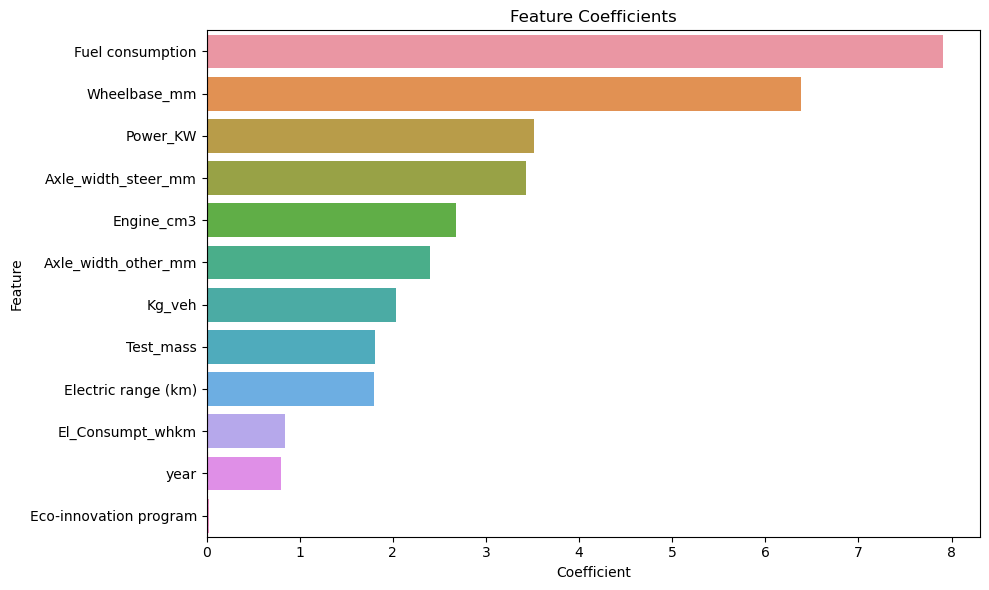

Energy Type: hybrid diesel
Best Alpha: 0.04037017258596558
Best R^2 Score: 0.934173067148437
Mean Squared Error: 11.787761976296485


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


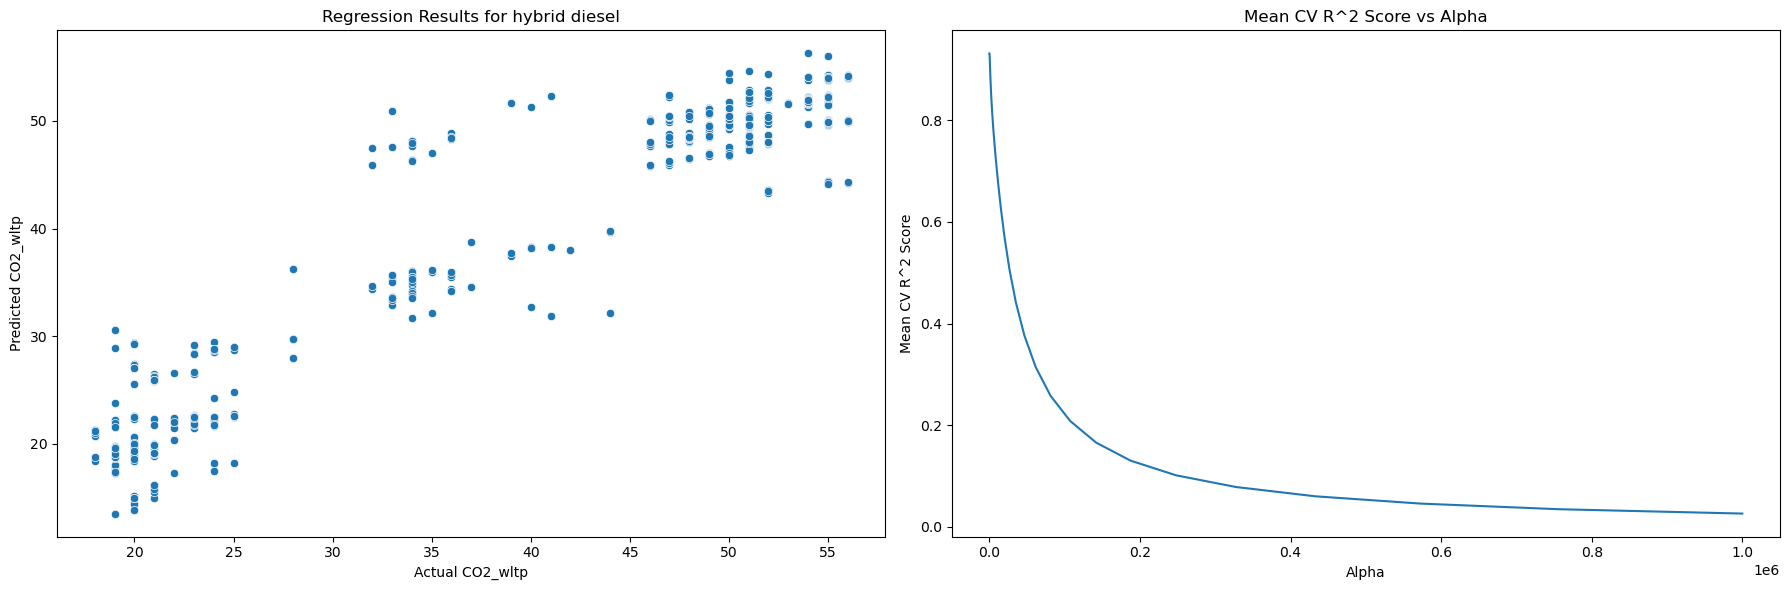

Feature Importances:
Wheelbase_mm: 5.844475122721088
Electric range (km): 4.583923440893396
El_Consumpt_whkm: 3.6165696903803526
year: 2.9014283728277332
Fuel consumption: 2.0630477059582013
Kg_veh: 1.9913634899744597
Test_mass: 1.951350213733346
Axle_width_steer_mm: 1.0448402552315075
Axle_width_other_mm: 0.9123479916695222
Eco-innovation program: 0.0
Erwltp (g/km): 0.0
Power_KW: 0.0


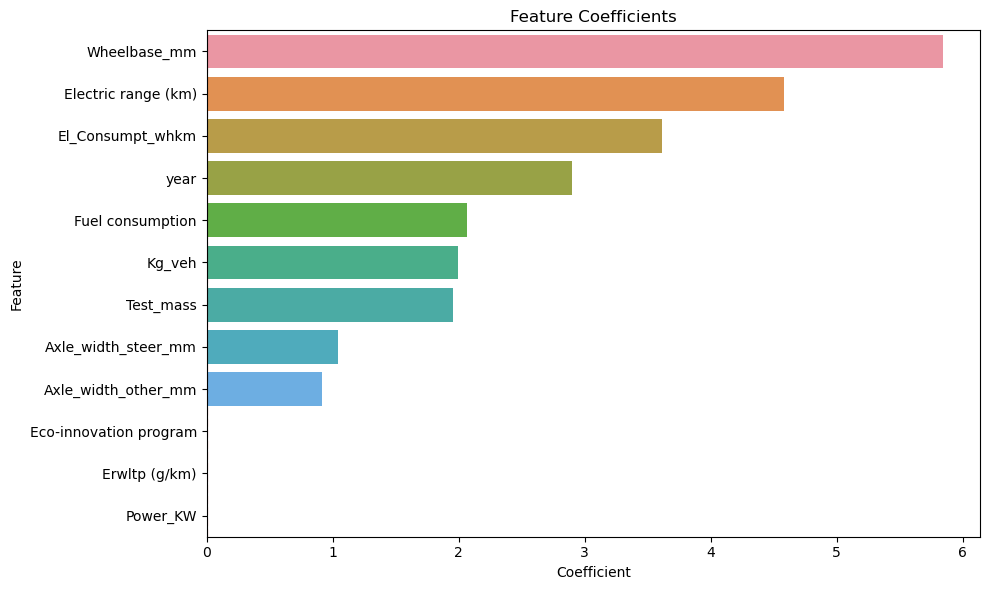

In [9]:
# Apply Ridge Regression for each energy type and all together with enhanced visualization
alphas = np.logspace(-6, 6, 100)
results = {}
for energy, features in features_dict.items():
    results[energy] = ridge_regression_with_random_search(df_clean, energy, features_dict, alphas)

Energy Type: All
Best Alpha: 8.111308307896872
Best R^2 Score: 0.8212409215201745
Mean Squared Error: 312.0476883872237


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


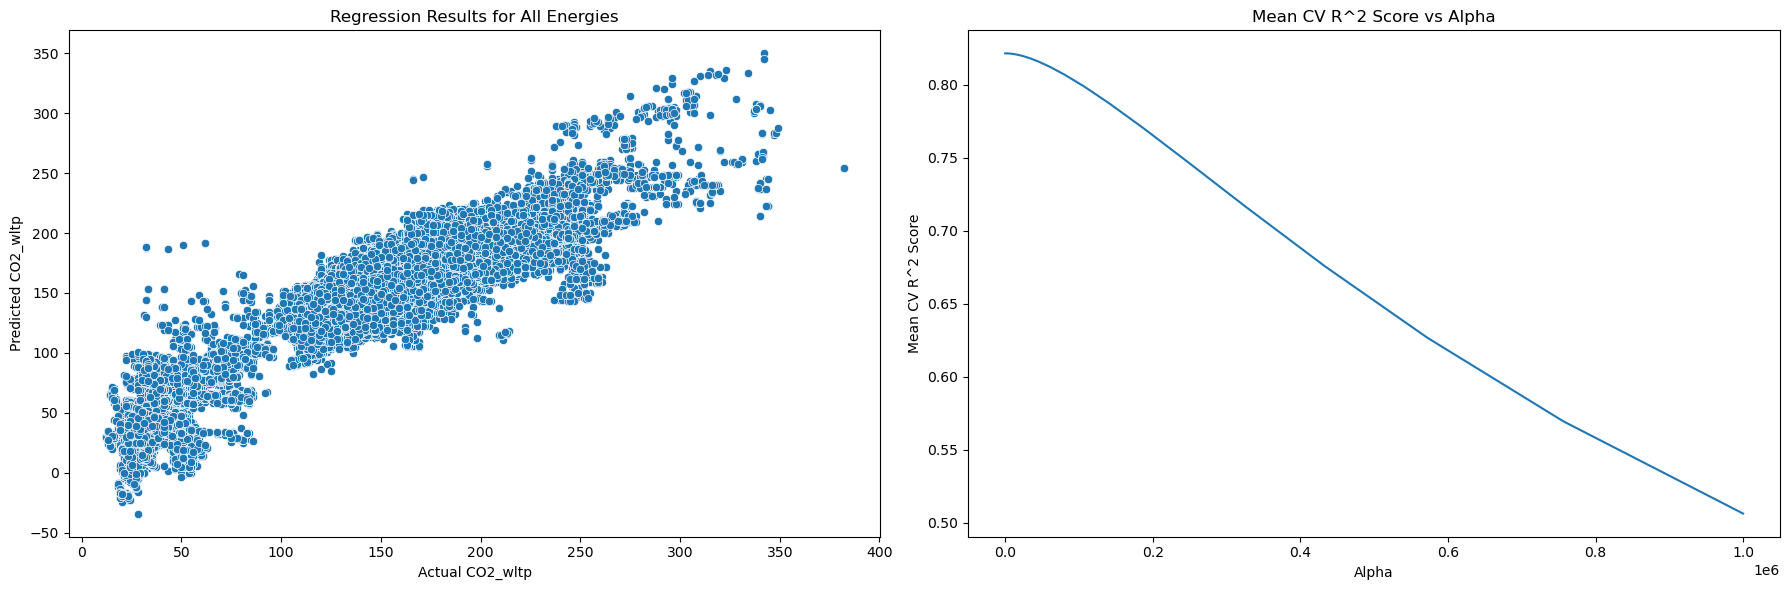

Feature Importances:
El_Consumpt_whkm: 25.79428057296672
Engine_cm3: 12.181076977842382
Fuel consumption: 11.337045981165947
year: 5.7353791410090444
Wheelbase_mm: 4.642135513876215
Power_KW: 3.872917338079822
Axle_width_other_mm: 3.4339896098616784
Erwltp (g/km): 2.9594970890741177
Axle_width_steer_mm: 2.9592000269289005
Kg_veh: 2.0911135730608237
Test_mass: 1.0427407271639335
Electric range (km): 0.8263431025297044
Eco-innovation program: 0.332361734456025


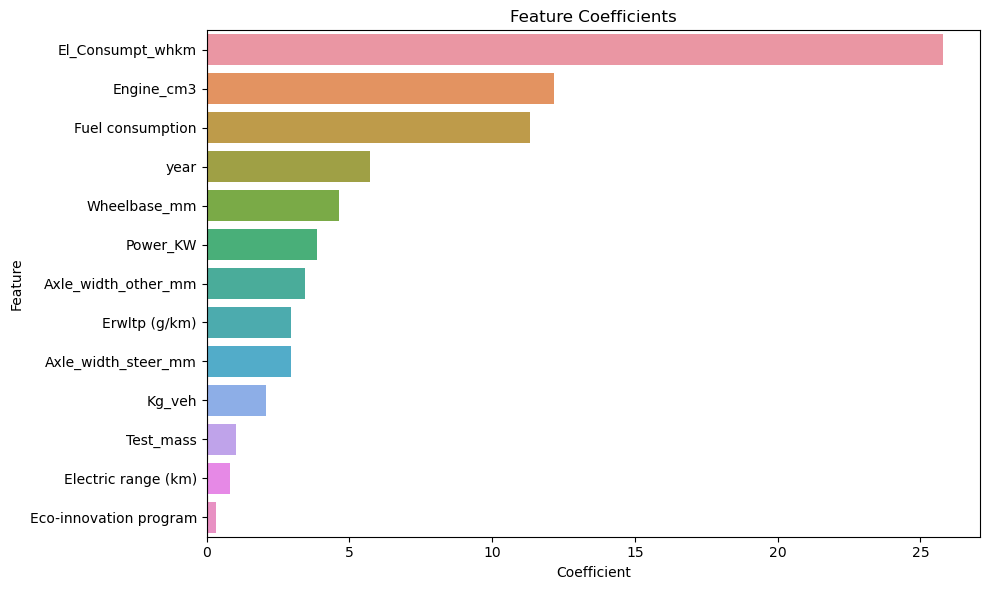

In [13]:
# Run regression on all energies together
all_energies = list(features_dict.keys())
results['all_energies'] = ridge_regression_with_random_search(df_clean, all_energies, features_dict, alphas)